<a href="https://colab.research.google.com/github/soseverse/Application-of-remote-sensing-and-deep-learning---Sand-mining-detection-at-Vietnam-Mekong-Delta/blob/main/sm_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.6 MB/s eta 0:00:00


### imported libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import yaml
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from IPython.display import display

from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### load dataset

In [ ]:
dataset_path = '/content/drive/MyDrive/sm_vmd_data'

def show_contents(path):
  for name in os.listdir(path):
    full_path = os.path.join(path, name)
    if os.path.isdir(full_path):
      print(f'{name}/ - {len(os.listdir(full_path))} files')

In [ ]:
show_contents(dataset_path)

train_labels/ - 2008 files
train_images/ - 2008 files


### dataset cleaning

In [ ]:
def remove_empty_labels(old_dir, new_dir):
  os.makedirs(new_dir, exist_ok = True)
  count = 0 # to count number of files with empty label
  for name in os.listdir(old_dir):
    full_path = os.path.join(old_dir, name)
    if os.path.isfile(full_path) and os.path.getsize(full_path) > 0:
      shutil.copy(full_path, new_dir)
    else:
      count = count + 1

  print(f'Total empty label files: {count}')

In [ ]:
label_dir = os.path.join(dataset_path, 'train_labels')
cleaned_data_dir = os.path.join(dataset_path, 'cleaned_dataset')

remove_empty_labels(label_dir, cleaned_data_dir)

Total empty label files: 289


### analysis of annotated objects

In [ ]:
# check data.yaml file
with open("/content/drive/MyDrive/sm_vmd_data/data.yaml", "r") as f:
    data_yaml = yaml.safe_load(f)


In [ ]:
nc = data_yaml['nc']
names = data_yaml['names']


### Get class IDs

In [ ]:
all_class_counts = {}

for filename in os.listdir(cleaned_data_dir):
    if not filename.endswith(".txt"):
        continue

    with open(os.path.join(cleaned_data_dir, filename)) as file:
        for line in file:
            class_id = int(line.split()[0])

            if class_id not in all_class_counts:
                all_class_counts[class_id] = 1
            else:
               all_class_counts[class_id] += 1


In [ ]:
all_class_counts

{1: 3706, 2: 9389, 0: 1181, 3: 255}

### valid classes

In [ ]:
for class_id in range(nc):
    class_name = names[class_id]
    count = all_class_counts[class_id]
    print(f"Class {class_id} ({class_name}): {count}")

Class 0 (barge with crane): 1181
Class 1 (cluster of boats): 3706
Class 2 (sand transport boat): 9389


### Handling invalid class

In [ ]:
invalid_classes = []

for class_id, count in all_class_counts.items():
    if class_id >= nc:
        invalid_classes.append((class_id, count))

if len(invalid_classes) > 0:
    print("\nInvalid classes found:")
    for item in invalid_classes:
        cid = item[0]
        count = item[1]
        print(f"Class ID {cid}: {count} annotations")
else:
    print("\nNo invalid classes found.")



Invalid classes found:
Class ID 3: 255 annotations


### Dataset Visualisation

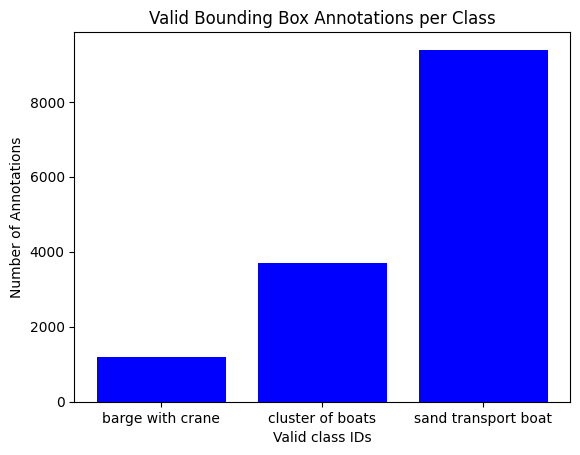

In [ ]:
class_ids = list(range(nc))
counts = [all_class_counts[class_id] for class_id in class_ids]
labels = [names[class_id] for class_id in class_ids]

plt.figure()
plt.bar(labels, counts, color = 'blue')
plt.xlabel("Valid class IDs")
plt.ylabel("Number of Annotations")
plt.title("Valid Bounding Box Annotations per Class")
plt.show()


### Dataset analysis wrt images

In [ ]:
class_images = {}

for filename in os.listdir(cleaned_data_dir):
    if not filename.endswith(".txt"):
        continue

    with open(os.path.join(cleaned_data_dir, filename)) as file:
        for line in file:
            class_id = int(line.split()[0])

            if class_id not in class_images:
                class_images[class_id] = []

            if filename not in class_images[class_id]:
                class_images[class_id].append(filename)


In [ ]:
print("Total images per valid class:")

for class_id in range(nc):
    class_name = names[class_id]
    image_count = len(class_images[class_id])
    print(f"Class {class_id} ({class_name}): {image_count} images")


Total images per valid class:
Class 0 (barge with crane): 631 images
Class 1 (cluster of boats): 1162 images
Class 2 (sand transport boat): 1435 images


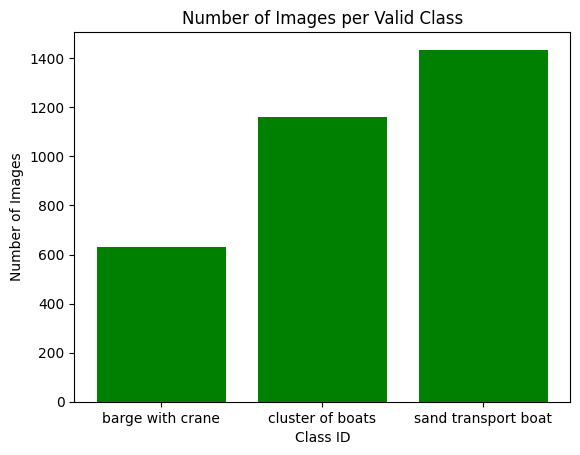

In [ ]:
valid_class_ids = []
image_counts = []

for class_id in range(nc):
    valid_class_ids.append(names[class_id])

    if class_id in class_images:
        image_counts.append(len(class_images[class_id]))
    else:
        image_counts.append(0)

plt.figure()
plt.bar(valid_class_ids, image_counts, color = 'green')
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.title("Number of Images per Valid Class")
plt.show()


### Validation dataset

In [ ]:
image_classes = {}

for filename in os.listdir(cleaned_data_dir):
  if not filename.endswith('txt'):
    continue
  with open(os.path.join(cleaned_data_dir, filename)) as file:
    for line in file:
      class_id = int(line.split()[0])
      if filename not in image_classes:
        image_classes[filename] = []

      if class_id not in image_classes[filename]:
        image_classes[filename].append(class_id)

In [ ]:
class_image_counts = {}

for classes in image_classes.values():
  for class_id in classes:
    if class_id not in class_image_counts:
      class_image_counts[class_id] = 1
    else:
      class_image_counts[class_id] += 1

In [ ]:
val_size = 0.20
target_val_counts = {}
for class_id in range(nc):
  if class_id in class_image_counts:
    target_val_counts[class_id] = int(class_image_counts[class_id] * val_size)
  else:
    target_val_counts[class_id] = 0

In [ ]:
target_val_counts

{0: 126, 1: 232, 2: 287}

### Extract validation images from dataset

In [ ]:
val_counts = {}

for class_id in target_val_counts:
  val_counts[class_id] = target_val_counts[class_id]

# store validation images in new list
val_images = []
image_names = list(image_classes.keys())
random.shuffle(image_names)

for image_name in image_names:
  classes = image_classes[image_name]
  for class_id in classes:
    if class_id in val_counts:
      if val_counts[class_id] > 0:
        val_images.append(image_name)

        # receeding count of val_counts
        for class_ in classes:
          if class_ in val_counts:
            if val_counts[class_] > 0:
              val_counts[class_] -= 1
        break


In [ ]:
train_images = []

for image_name in image_classes:
  if image_name not in val_images:
    train_images.append(image_name)

print(f'Total validation images: ({len(val_images)})')
print(f'Total training images: ({len(train_images)})')

Total validation images: (339)
Total training images: (1380)


In [ ]:
new_dataset_path = 'vmd'

train_images_dir = os.path.join(new_dataset_path, 'images/train')
train_labels_dir = os.path.join(new_dataset_path, 'labels/train')

val_images_dir = os.path.join(new_dataset_path, 'images/val')
val_labels_dir = os.path.join(new_dataset_path, 'labels/val')

os.makedirs(train_images_dir, exist_ok = True)
os.makedirs(train_labels_dir, exist_ok = True)
os.makedirs(val_images_dir, exist_ok = True)
os.makedirs(val_labels_dir, exist_ok = True)



### for train images

In [ ]:
for label_name in train_images:

    image_name = label_name.replace(".txt", ".jpg")

    shutil.copy(
        os.path.join("/content/drive/MyDrive/sm_vmd_data/train_images", image_name),
        os.path.join(train_images_dir, image_name)
    )


    shutil.copy(
        os.path.join(cleaned_data_dir, label_name),
        os.path.join(train_labels_dir, label_name)
    )


### for validation images

In [ ]:
for label_name in val_images:

    image_name = label_name.replace(".txt", ".jpg")

    shutil.copy(
        os.path.join("/content/drive/MyDrive/sm_vmd_data/train_images", image_name),
        os.path.join(val_images_dir, image_name)
    )

    shutil.copy(
        os.path.join(cleaned_data_dir, label_name),
        os.path.join(val_labels_dir, label_name)
    )


In [ ]:
print("Train images:", len(os.listdir(train_images_dir)))
print("Train labels:", len(os.listdir(train_labels_dir)))
print("Val images:", len(os.listdir(val_images_dir)))
print("Val labels:", len(os.listdir(val_labels_dir)))


Train images: 1380
Train labels: 1380
Val images: 339
Val labels: 339


## VGG 16 - Baseline Model

### create VGG-16 dataset for classification

In [ ]:
images_dir = "/content/vmd/images/train"
labels_dir = "/content/vmd/labels/train"
vgg_16_path = "/content/vgg_16"

os.makedirs(vgg_16_path, exist_ok=True)

for label_file in os.listdir(labels_dir):

    if not label_file.endswith(".txt"):
        continue

    image_file = label_file.replace(".txt", ".jpg")

    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, label_file)

    if not os.path.exists(image_path):
        continue

    img = Image.open(image_path)
    w, h = img.size

    with open(label_path) as f:
        for i, line in enumerate(f):

            parts = line.split()
            class_id = int(parts[0])

            if class_id >= 3:
                continue
            # Yolo coordinates
            xc = float(parts[1])
            yc = float(parts[2])
            bw = float(parts[3])
            bh = float(parts[4])

            x1 = int((xc - bw/2) * w)
            y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w)
            y2 = int((yc + bh/2) * h)

            # Bounding box axis boundary
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(w, x2)
            y2 = min(h, y2)

            # invalid crops
            if x2 <= x1 or y2 <= y1:
                continue

            crop = img.crop((x1, y1, x2, y2))

            class_folder = os.path.join(vgg_16_path, str(class_id))
            os.makedirs(class_folder, exist_ok=True)

            save_name = f"{label_file[:-4]}_{i}.jpg"
            save_path = os.path.join(class_folder, save_name)

            crop.save(save_path)

print("VGG16 crops created successfully.")


VGG16 crops created successfully.


In [ ]:
print(os.listdir(vgg_16_path))

['0', '2', '1']


### Splitting crops into train and validation set

In [ ]:
source_dir = "/content/vgg_16"
base_dir = "/content/vgg16_data"

train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

random.seed(42)

for class_id in os.listdir(source_dir):

    class_source = os.path.join(source_dir, class_id)
    if not os.path.isdir(class_source):
        continue

    class_train = os.path.join(train_dir, class_id)
    class_val   = os.path.join(val_dir, class_id)

    os.makedirs(class_train, exist_ok=True)
    os.makedirs(class_val, exist_ok=True)

    images = os.listdir(class_source)
    random.shuffle(images)

    split_idx = int(len(images) * 0.8)

    train_imgs = images[:split_idx]
    val_imgs   = images[split_idx:]

    for img in train_imgs:
        shutil.copy(os.path.join(class_source, img),
                    os.path.join(class_train, img))

    for img in val_imgs:
        shutil.copy(os.path.join(class_source, img),
                    os.path.join(class_val, img))


### Data Preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    "/content/vgg16_data/train",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    "/content/vgg16_data/val",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)


Found 8972 images belonging to 3 classes.
Found 2244 images belonging to 3 classes.


### Building VGG-16 Model

In [ ]:
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False


In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
output = Dense(3, activation="softmax")(x)




In [ ]:
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.7016 - loss: 0.9694 - val_accuracy: 0.7652 - val_loss: 0.5875
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.7898 - loss: 0.5588 - val_accuracy: 0.7687 - val_loss: 0.5822
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.7987 - loss: 0.5318 - val_accuracy: 0.7986 - val_loss: 0.5436
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8123 - loss: 0.5017 - val_accuracy: 0.7799 - val_loss: 0.5722
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8227 - loss: 0.4726 - val_accuracy: 0.8066 - val_loss: 0.5111
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8279 - loss: 0.4551 - val_accuracy: 0.8102 - val_loss: 0.5057
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8356 - loss: 0.4316 - val_accuracy: 0.8160 - val_loss: 0.5028
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8468 - loss: 0.4193 - 

### Check accuracy and loss for baseline model

In [ ]:
val_loss, val_acc = model.evaluate(val_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8005 - loss: 0.5356
Validation Loss: 0.4987066090106964
Validation Accuracy: 0.8163992762565613


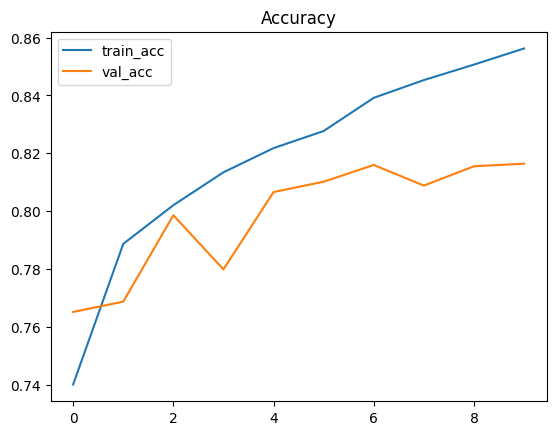

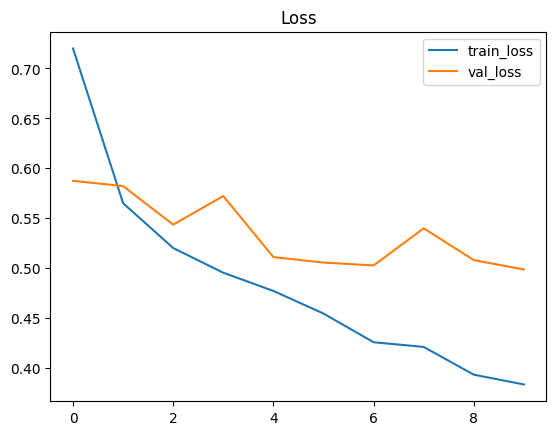

In [ ]:
# Accuracy plot
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

# Loss plot
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()


### VGG-16 Model tuning

In [ ]:
# Adding 4 more layers
base_model.trainable = True

for layer in base_model.layers[:-4]:
    layer.trainable = False


In [ ]:
model_ft1 = Model(inputs=base_model.input, outputs=output)

In [ ]:
model_ft1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
history_ft1 = model_ft1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


Epoch 1/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.8763 - loss: 0.3350 - val_accuracy: 0.7972 - val_loss: 0.5418
Epoch 2/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8895 - loss: 0.2930 - val_accuracy: 0.8262 - val_loss: 0.5009
Epoch 3/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8997 - loss: 0.2763 - val_accuracy: 0.8119 - val_loss: 0.5241
Epoch 4/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9050 - loss: 0.2598 - val_accuracy: 0.8271 - val_loss: 0.4993
Epoch 5/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9151 - loss: 0.2341 - val_accuracy: 0.8155 - val_loss: 0.5395


In [ ]:
val_loss, val_acc = model_ft1.evaluate(val_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8230 - loss: 0.5330
Validation Loss: 0.5395163297653198
Validation Accuracy: 0.8155080080032349


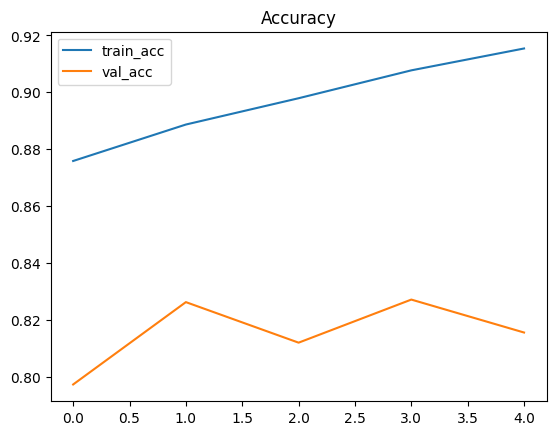

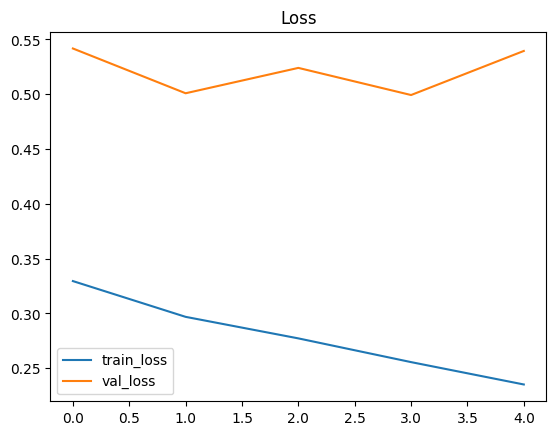

In [ ]:
# Accuracy plot
plt.plot(history_ft1.history["accuracy"], label="train_acc")
plt.plot(history_ft1.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

# Loss plot
plt.plot(history_ft1.history["loss"], label="train_loss")
plt.plot(history_ft1.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()


In [ ]:
# Adding another 8 layers
for layer in base_model.layers[:-8]:
    layer.trainable = False



In [ ]:
model_ft2 = Model(inputs=base_model.input, outputs=output)

In [ ]:
model_ft2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
history_ft2 = model_ft2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


Epoch 1/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.9309 - loss: 0.2079 - val_accuracy: 0.8338 - val_loss: 0.4978
Epoch 2/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9302 - loss: 0.1976 - val_accuracy: 0.8307 - val_loss: 0.5038
Epoch 3/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9422 - loss: 0.1722 - val_accuracy: 0.8244 - val_loss: 0.5030
Epoch 4/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9497 - loss: 0.1664 - val_accuracy: 0.8280 - val_loss: 0.5047
Epoch 5/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9470 - loss: 0.1606 - val_accuracy: 0.8302 - val_loss: 0.5084


In [ ]:
val_loss_vgg, val_acc_vgg = model_ft2.evaluate(val_generator)

print("Validation Loss:", val_loss_vgg)
print("Validation Accuracy:", val_acc_vgg)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8388 - loss: 0.5034
Validation Loss: 0.5084319114685059
Validation Accuracy: 0.8302139043807983


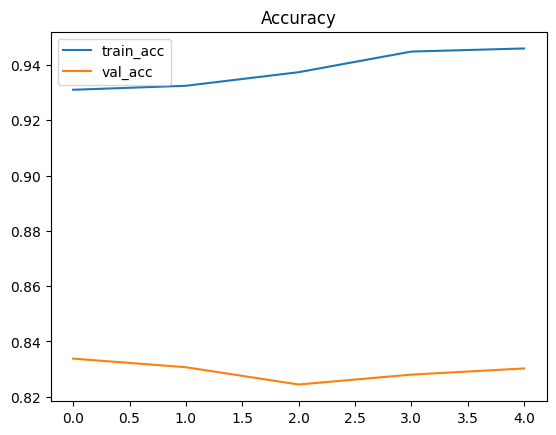

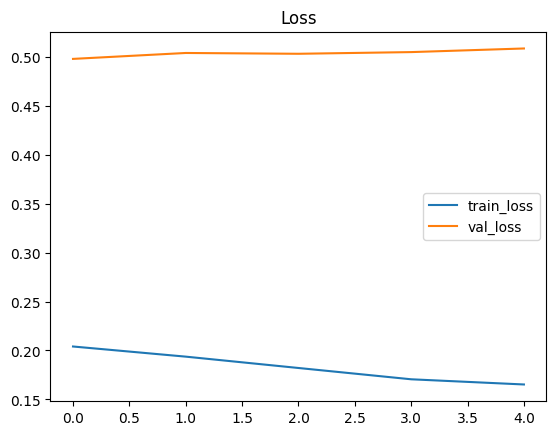

In [ ]:
# Accuracy plot
plt.plot(history_ft2.history["accuracy"], label="train_acc")
plt.plot(history_ft2.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

# Loss plot
plt.plot(history_ft2.history["loss"], label="train_loss")
plt.plot(history_ft2.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()


### Test Model

In [ ]:
true_labels = val_generator.classes
val_generator.reset()
predictions = model_ft1.predict(val_generator)
pred_labels = np.argmax(predictions, axis=1)

71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step


### Confusion Matrix

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:")
print(cm)



Confusion Matrix:
[[ 10  54 125]
 [ 40 154 385]
 [ 96 381 999]]


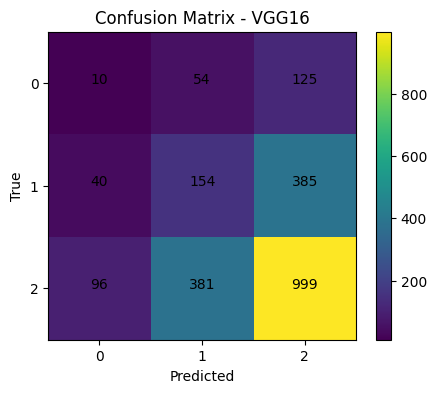

In [ ]:
# Visualise confusion matrix
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap='viridis')
plt.title("Confusion Matrix - VGG16")
plt.colorbar()

class_names = list(val_generator.class_indices.keys())
plt.xticks(range(len(class_names)), class_names)
plt.yticks(range(len(class_names)), class_names)

plt.xlabel("Predicted")
plt.ylabel("True")

# Add values to the plot
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 horizontalalignment="center")

plt.show()



### Classification Report

In [ ]:
print(classification_report(true_labels, pred_labels, target_names=class_names))

              precision    recall  f1-score   support

           0       0.07      0.05      0.06       189
           1       0.26      0.27      0.26       579
           2       0.66      0.68      0.67      1476

    accuracy                           0.52      2244
   macro avg       0.33      0.33      0.33      2244
weighted avg       0.51      0.52      0.51      2244



### Building the ResNet-50 Model

In [ ]:
# Let's work with a Pre-trained Imagenet model
resnet_base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)
resnet_base_model.trainable = False

In [ ]:
x = resnet_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)

output = Dense(3, activation="softmax")(x)




In [ ]:
resnet_model = Model(inputs=resnet_base_model.input, outputs=output)

In [ ]:
resnet_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_resnet = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
    )

Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 31s 76ms/step - accuracy: 0.6578 - loss: 0.8761 - val_accuracy: 0.6814 - val_loss: 0.7831
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6874 - loss: 0.7848 - val_accuracy: 0.6796 - val_loss: 0.7714
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.6842 - loss: 0.7781 - val_accuracy: 0.6814 - val_loss: 0.7716
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6896 - loss: 0.7734 - val_accuracy: 0.6809 - val_loss: 0.7691
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.6924 - loss: 0.7657 - val_accuracy: 0.6791 - val_loss: 0.7832
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6953 - loss: 0.7672 - val_accuracy: 0.6836 - val_loss: 0.7731
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6912 - loss: 0.7700 - val_accuracy: 0.6845 - val_loss: 0.7816
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6922 - loss: 0.7652 - 

In [ ]:
val_loss_resnet, val_acc_resnet = resnet_model.evaluate(val_generator)

print("ResNet50 Final Validation Accuracy:", val_acc_resnet)
print("ResNet50 Final Validation Loss:", val_loss_resnet)

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6707 - loss: 0.8042
ResNet50 Final Validation Accuracy: 0.6818181872367859
ResNet50 Final Validation Loss: 0.7853585481643677


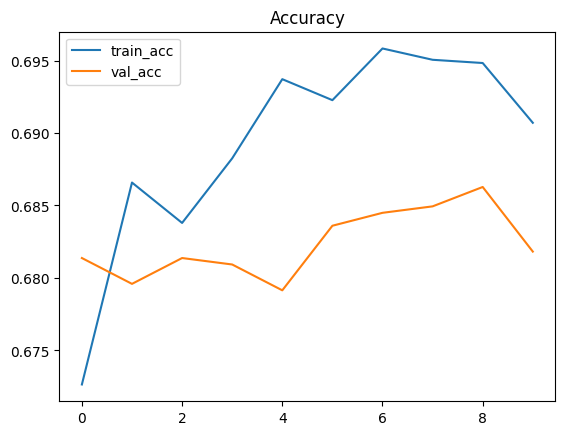

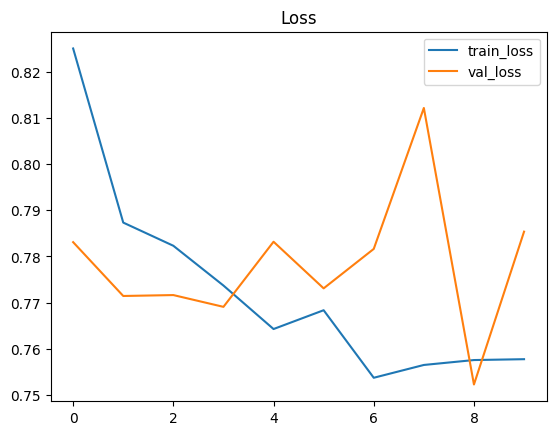

In [ ]:
# Accuracy plot
plt.plot(history_resnet.history["accuracy"], label="train_acc")
plt.plot(history_resnet.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

# Loss plot
plt.plot(history_resnet.history["loss"], label="train_loss")
plt.plot(history_resnet.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()


In [ ]:
# checking number of layers
len(resnet_base_model.layers)

175

### Finetuning ResNet50

In [ ]:
resnet_base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False


In [ ]:
resnet_model_ft1 = Model(inputs=resnet_base_model.input, outputs=output)

In [ ]:
resnet_model_ft1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_resnet_ft1 = resnet_model_ft1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


Epoch 1/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 93s 149ms/step - accuracy: 0.6481 - loss: 2.5525 - val_accuracy: 0.6578 - val_loss: 3.0928
Epoch 2/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.7737 - loss: 0.6413 - val_accuracy: 0.6582 - val_loss: 3.0799
Epoch 3/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.8336 - loss: 0.4367 - val_accuracy: 0.6845 - val_loss: 1.2635
Epoch 4/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - accuracy: 0.8668 - loss: 0.3562 - val_accuracy: 0.7687 - val_loss: 0.7040
Epoch 5/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.8966 - loss: 0.2801 - val_accuracy: 0.7852 - val_loss: 0.5860


In [ ]:
val_loss_resnet, val_acc_resnet = resnet_model_ft1.evaluate(val_generator)

print("ResNet50 Final Validation Accuracy:", val_acc_resnet)
print("ResNet50 Final Validation Loss:", val_loss_resnet)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7843 - loss: 0.6228
ResNet50 Final Validation Accuracy: 0.7852050065994263
ResNet50 Final Validation Loss: 0.5860484838485718


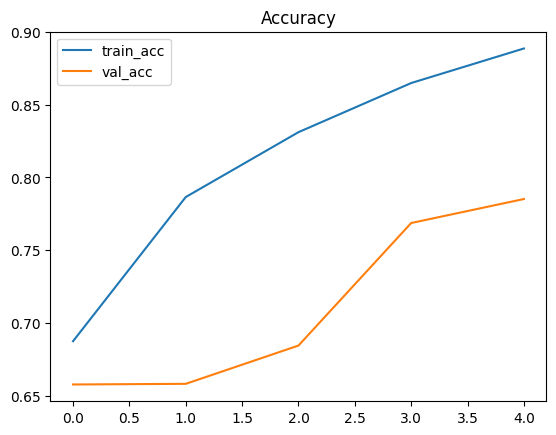

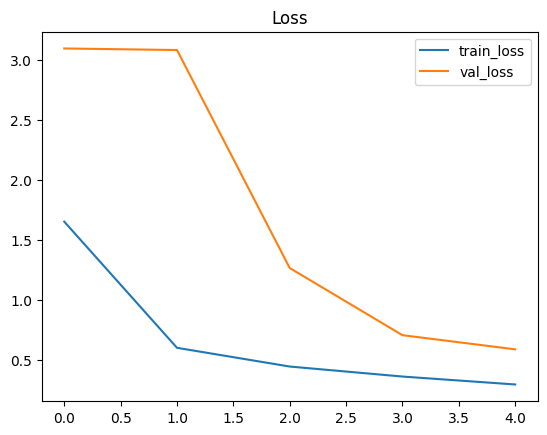

In [ ]:
# Accuracy plot
plt.plot(history_resnet_ft1.history["accuracy"], label="train_acc")
plt.plot(history_resnet_ft1.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

# Loss plot
plt.plot(history_resnet_ft1.history["loss"], label="train_loss")
plt.plot(history_resnet_ft1.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()


In [ ]:
resnet_base_model.trainable = True

for layer in base_model.layers[:-60]:
    layer.trainable = False


In [ ]:
resnet_model_ft2 = Model(inputs=resnet_base_model.input, outputs=output)

In [ ]:
resnet_model_ft2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_resnet_ft2 = resnet_model_ft2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


Epoch 1/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 93s 152ms/step - accuracy: 0.8554 - loss: 0.4130 - val_accuracy: 0.8008 - val_loss: 0.5562
Epoch 2/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.9065 - loss: 0.2601 - val_accuracy: 0.8115 - val_loss: 0.6346
Epoch 3/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9299 - loss: 0.1870 - val_accuracy: 0.8142 - val_loss: 0.7099
Epoch 4/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9491 - loss: 0.1387 - val_accuracy: 0.8311 - val_loss: 0.6300
Epoch 5/5
281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.9559 - loss: 0.1336 - val_accuracy: 0.8431 - val_loss: 0.6111


In [ ]:
val_loss_resnet, val_acc_resnet = resnet_model_ft2.evaluate(val_generator)

print("ResNet50 Final Validation Accuracy:", val_acc_resnet)
print("ResNet50 Final Validation Loss:", val_loss_resnet)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8493 - loss: 0.5715
ResNet50 Final Validation Accuracy: 0.843137264251709
ResNet50 Final Validation Loss: 0.6110631823539734


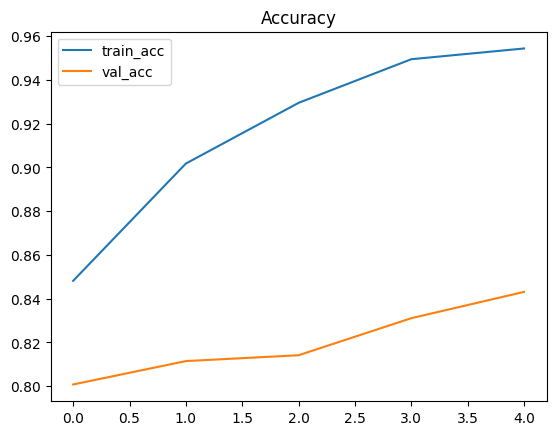

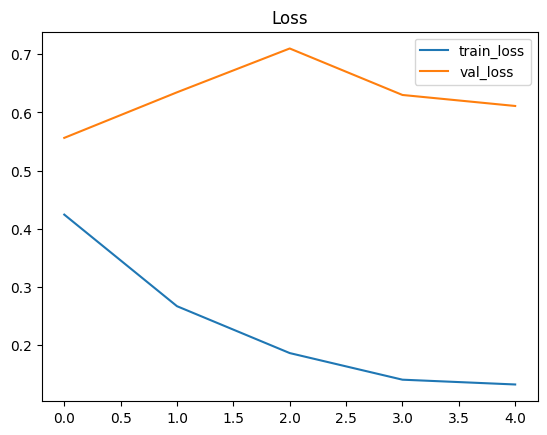

In [ ]:
# Accuracy plot
plt.plot(history_resnet_ft2.history["accuracy"], label="train_acc")
plt.plot(history_resnet_ft2.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

# Loss plot
plt.plot(history_resnet_ft2.history["loss"], label="train_loss")
plt.plot(history_resnet_ft2.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()


### Confusion matrix for ResNet-50

In [ ]:
val_generator.reset()
resnet_predictions = resnet_model_ft2.predict(val_generator)
resnet_pred_labels = np.argmax(resnet_predictions, axis=1)

71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step


Confusion Matrix - ResNet50:
[[ 23  37 129]
 [ 56 121 402]
 [133 349 994]]


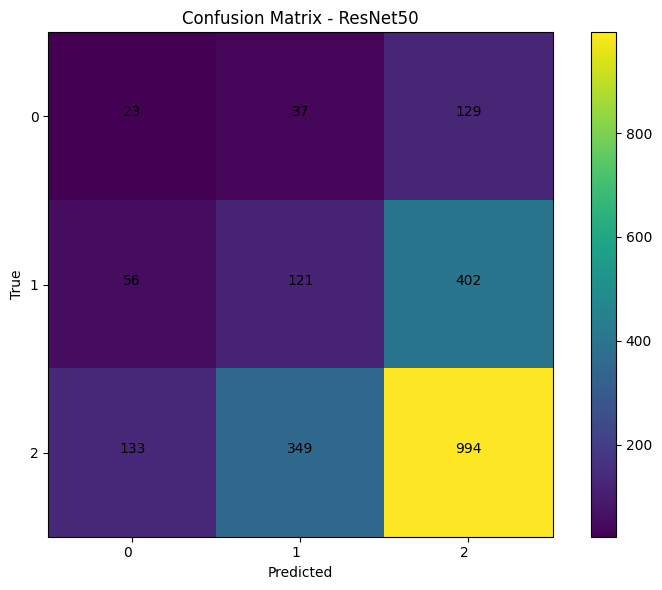

In [ ]:
cm_resnet = confusion_matrix(true_labels, resnet_pred_labels)
print("Confusion Matrix - ResNet50:")
print(cm_resnet)

plt.figure(figsize=(8, 6))
plt.imshow(cm_resnet, interpolation='nearest', cmap='viridis')
plt.title("Confusion Matrix - ResNet50")
plt.colorbar()

class_names = list(val_generator.class_indices.keys())
plt.xticks(range(len(class_names)), class_names, ha='right')
plt.yticks(range(len(class_names)), class_names)

plt.xlabel("Predicted")
plt.ylabel("True")

# Add values to the plot
for i in range(cm_resnet.shape[0]):
    for j in range(cm_resnet.shape[1]):
        plt.text(j, i, str(cm_resnet[i, j]),
                 horizontalalignment="center")

plt.tight_layout()
plt.show()

In [ ]:
print("\nResNet50 Classification Report:")
print(classification_report(true_labels, resnet_pred_labels, target_names=class_names))


ResNet50 Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.12      0.11       189
           1       0.24      0.21      0.22       579
           2       0.65      0.67      0.66      1476

    accuracy                           0.51      2244
   macro avg       0.33      0.33      0.33      2244
weighted avg       0.50      0.51      0.50      2244



### Classification Model Comparison

In [ ]:
print(f"VGG16:  Acc: {val_acc_vgg:.4f}, Loss: {val_loss_vgg:.4f}")
print(f"ResNet50: Acc: {val_acc_resnet:.4f}, Loss: {val_loss_resnet:.4f}")

VGG16:  Acc: 0.8302, Loss: 0.5084
ResNet50: Acc: 0.8431, Loss: 0.6111


## Building Yolo-v8 Model

In [ ]:
model = YOLO("yolov8m.pt")

In [ ]:
print(os.listdir("/content/vmd/images/train")[:5])
print(os.listdir("/content/vmd/images/val")[:5])

['014-2-_png.rf.daee2c30d99e012c9881b0bb9987aa96.jpg', '0038_jpg.rf.86a6a9920daadaa8aa17c54da37733fb.jpg', '152_png.rf.fe6967c854be5cfb43001335231f3839.jpg', '049_png.rf.7a9d3ea9df56fdcde3176d3961b3c8f1.jpg', '031-5-_png.rf.70a4b6065bc9e452579503cd42608ed2.jpg']
['035-3-_png.rf.02f565658e539b487f6b2437a9dd2999.jpg', '163_png.rf.26cc4f98ec10f7fb4815cbeb8ea1dc30.jpg', '217-5-_png.rf.706c0fb3a445f47ac1717b0957178dce.jpg', '145-2-_png.rf.0050d820e3503f7116e49fc02a4636f1.jpg', 'Screenshot-57-_png.rf.5df9906f6f1c376bad51c67a1ca244ca.jpg']


In [ ]:
results = model.train(
    data="/content/drive/MyDrive/sm_vmd_data/data.yaml",
    epochs=100,
    imgsz=768,
    batch=32,
    patience = 20,
    device = 0
)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (NVIDIA A100-SXM4-80GB, 81153MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/sm_vmd_data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, 

In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")

In [ ]:
metrics = model.val()
metrics

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (NVIDIA A100-SXM4-80GB, 81153MiB)
Model summary (fused): 93 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 513.3±147.4 MB/s, size: 18.5 KB)
val: Scanning /content/vmd/labels/val.cache... 339 images, 0 backgrounds, 9 corrupt: 100% ━━━━━━━━━━━━ 339/339 142.2Mit/s 0.0s
val: /content/vmd/images/val/0026_jpg.rf.96087a8c23194fe92e6781cf53109eb2.jpg: 1 duplicate labels removed
val: /content/vmd/images/val/Screenshot-248-_png.rf.aab16a57cf5b02f0ab69f28a88c45f7d.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/vmd/images/val/Screenshot-255-_png.rf.e9ed7324fe56dfd251f997e92258447a.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/vmd/images/val/Screenshot-265-_png.rf.96471af7489b85aa452e3bd186bc193d.jpg: ignoring corrupt image/labe

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e1ad4384aa0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
model = YOLO("yolov8l.pt")

results = model.train(
    data="/content/drive/MyDrive/sm_vmd_data/data.yaml",
    epochs=200,
    imgsz=1024,
    batch=32,
    patience=50,
    device=0
)


Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (NVIDIA A100-SXM4-80GB, 81153MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/sm_vmd_data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True